# Walmart Sales Analysis

## Objective
The idea of this project is to practice turning raw data into insights that matter for a business.  
We’re looking at Walmart’s weekly sales data and asking: *what patterns can we find that would actually help a manager make decisions?*


## Business Questions
1. **Concentration:** How many stores are responsible for 50% and 80% of Walmart’s total sales?  
   → Why: If most sales come from just a few stores, those stores need more focus (inventory, promotions, staff).

2. **Holiday Impact:** Do sales really jump during holiday weeks, and by how much?  
   → Why: Managers can use this to plan ahead — schedule more workers and stock more products.

3. **Seasonality:** Which months or seasons bring in the most sales?  
   → Why: This helps understand yearly cycles and plan marketing campaigns.

4. **Trend Direction:** Over the years, are sales going up or down overall?  
   → Why: Shows whether demand is growing or cooling off in the long run.

5. **Macro Factors:** Do things like temperature, fuel price, CPI, or unemployment affect sales?  
   → Why: External conditions often change customer spending — good to know what matters most.


## Dataset

- **Source:** Kaggle — *Walmart Sales* dataset. (https://www.kaggle.com/datasets/mikhail1681/walmart-sales/data)
- **File Used:** `Walmart_Sales.csv`  

## Load Data

The goal here is just to **make sure the file loads correctly** and then **get a quick idea** of what’s inside.


In [6]:
import pandas as pd

# Load CSV
df = pd.read_csv("../data/Walmart_Sales.csv")

# Look at the first few rows
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [7]:
# Convert the Date column to proper datetime format (dataset uses dd-mm-YYYY)
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")

In [11]:
# Shape = number of rows, number of columns
print("Shape of dataset:", df.shape)

# Data types of each column
print("\n")
print("Column info:")
print(df.dtypes)

# Check for missing values
print("\nMissing values per column:")
print(df.isna().sum())

Shape of dataset: (6435, 8)


Column info:
Store                    int64
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag             int64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
dtype: object

Missing values per column:
Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


In [13]:
# Quick overview of min & max for all columns
df.describe().loc[["min", "max"]]

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week
min,1.0,2010-02-05 00:00:00,209986.25,0.0,-2.06,2.472,126.064000,3.879,2010.0,1.0,1.0
max,45.0,2012-10-26 00:00:00,3818686.45,1.0,100.14,4.468,227.232807,14.313,2012.0,12.0,52.0


## Feature Engineering

The goal here is to add time-based columns so grouping/plotting is easier (this is like adding helper columns in Excel).

In [12]:
# year, month, and ISO week number (1–53)
df["Year"]  = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Week"] = df["Date"].dt.isocalendar().week.astype(int)

# simple season label from month
def month_to_season(m):
    if m in (3, 4, 5): return "Spring"
    if m in (6, 7, 8): return "Summer"
    if m in (9, 10, 11): return "Fall"
    return "Winter"

df["Season"] = df["Month"].apply(month_to_season)

# check
df[["Date","Year","Month","Week","Season"]].head()

,Date,Year,Month,Week,Season
0,2010-02-05,2010,2,5,Winter
1,2010-02-12,2010,2,6,Winter
2,2010-02-19,2010,2,7,Winter
3,2010-02-26,2010,2,8,Winter
4,2010-03-05,2010,3,9,Spring


In [18]:
# check table
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,Season
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5,Winter
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,6,Winter
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,7,Winter
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,8,Winter
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,9,Spring


## Concentration

The goal here is to sort stores by total sales, then see how many stores we need to reach 50% and 80% of total revenue.

**Why 50% and 80%?**
- **50%** = “How many stores make up half of total sales?” Easy story for business partners.
- **80%** = classic **Pareto 80/20** check. If a small number of stores reach 80%, sales are highly concentrated.

In [80]:
import sqlite3

# Create a temporary SQL database in memory
con = sqlite3.connect(":memory:")

# Copy our DataFrame into SQL
df_sql = df.copy()
df_sql["Date"] = df_sql["Date"].dt.strftime("%Y-%m-%d")  # convert datetime to string for SQL
df_sql.to_sql("walmart_sales", con, index=False, if_exists="replace")

# Find the total sales per store
query_totals = """
SELECT Store, SUM(Weekly_Sales) AS total_sales
FROM walmart_sales
GROUP BY Store
ORDER BY total_sales DESC;
"""
store_totals = pd.read_sql(query_totals, con)
store_totals.head(10)

# Calculate cumulative share
store_totals["Cumulative_Sales"] = store_totals["total_sales"].cumsum()
total_sum = store_totals["total_sales"].sum()
store_totals["Cumulative_Share"] = store_totals["Cumulative_Sales"] / total_sum
store_totals.head(10)

# Find store numbers to 50 and N80
n50 = (store_totals["Cumulative_Share"] < 0.5).sum() + 1  # +1 b/c start from 0
n80 = (store_totals["Cumulative_Share"] < 0.8).sum() + 1

print(f"Stores we needed to reach 50% of total sales: {n50}")
print(f"Stores we needed to reach 80% of total sales: {n80}")

cross_50 = store_totals.iloc[[n50 - 1]]
display(cross_50)

cross_80 = store_totals.iloc[[n80 - 1]]
display(cross_80)

# To double check
# store_totals.head(27)

top_50_stores = store_totals.iloc[:n50]["Store"].tolist()
print("The list of stores needed to reach 50%:")
print(top_50_stores)

top_80_stores = store_totals.iloc[:n80]["Store"].tolist()
print("The list of stores needed to reach 80%:")
print(top_80_stores)

Stores we needed to reach 50% of total sales: 14
Stores we needed to reach 80% of total sales: 27


,Store,total_sales,Cumulative_Sales,Cumulative_Share
13,24,1.940160e+08,3.429935e+09,0.509103


,Store,total_sales,Cumulative_Sales,Cumulative_Share
26,17,1.277821e+08,5.416591e+09,0.80398


The list of stores needed to reach 50%:
[20, 4, 14, 13, 2, 10, 27, 6, 1, 39, 19, 31, 23, 24]
The list of stores needed to reach 80%:
[20, 4, 14, 13, 2, 10, 27, 6, 1, 39, 19, 31, 23, 24, 11, 28, 41, 32, 18, 22, 12, 26, 34, 40, 35, 8, 17]


## Holiday Impact

The goal here is to understand how holidays impact Walmart’s weekly sales.

In [122]:
# Separate data into holiday and non-holiday weeks
holiday_sales = df[df["Holiday_Flag"] == 1]
non_holiday_sales = df[df["Holiday_Flag"] == 0]

# Display how many holiday and non-holiday weeks we have
print(f"Holiday weeks: {holiday_sales.shape[0]}")
print(f"Non-holiday weeks: {non_holiday_sales.shape[0]}")

# Calculate mean weekly sales
holiday_avg = holiday_sales["Weekly_Sales"].mean()
nonholiday_avg = non_holiday_sales["Weekly_Sales"].mean()

print(f"Average Weekly Sales during Holiday Weeks: ${holiday_avg:,.2f}")
print(f"Average Weekly Sales during Non-Holiday Weeks: ${nonholiday_avg:,.2f}")

Holiday weeks: 450
Non-holiday weeks: 5985
Average Weekly Sales during Holiday Weeks: $1,122,887.89
Average Weekly Sales during Non-Holiday Weeks: $1,041,256.38


/var/folders/m7/ss8z8qzd41xf6brzq59dgl9c0000gn/T/ipykernel_3060/1064344595.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


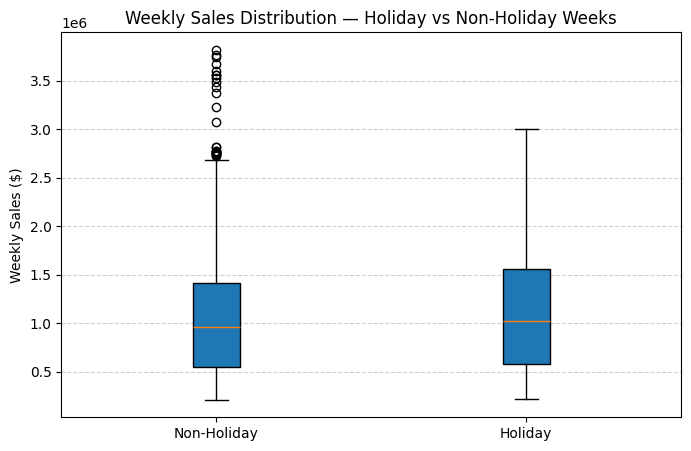

In [125]:
import matplotlib.pyplot as plt

# Box plot
plt.figure(figsize=(8,5))
plt.boxplot(
    [non_holiday_sales["Weekly_Sales"], holiday_sales["Weekly_Sales"]],
    labels=["Non-Holiday", "Holiday"],
    patch_artist=True
)
plt.title("Weekly Sales Distribution — Holiday vs Non-Holiday Weeks")
plt.ylabel("Weekly Sales ($)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


## Seasonality

The goal here is to

## Trend Direction

The goal here is to

## Macro Factors

The goal here is to